<a href="https://colab.research.google.com/github/uichann/My_Repository/blob/main/RNN_LSTM_%EC%8B%A4%EC%8A%B5(%ED%95%9C%EA%B5%AD%EA%B0%80%EC%8A%A4%EA%B3%B5%EC%82%AC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import os

%matplotlib inline
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15,20)

plt.rcParams['font.family'] = 'NanumGothic'

In [2]:
!pip install finance-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import FinanceDataReader as fdr

In [4]:
gas = fdr.DataReader('036460')

In [5]:
gas.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-12-15,32093,32190,30449,31417,1294970,NaN
1999-12-16,31223,33156,30595,31707,1391780,0.009231
1999-12-17,31078,31319,27550,29290,700910,-0.076229
1999-12-20,28516,29290,28516,29290,632430,0.000000
1999-12-21,28758,28999,28710,28710,479550,-0.019802


In [6]:
STOCK_CODE = '036460'

In [7]:
stock = fdr.DataReader(STOCK_CODE)
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-12-15,32093,32190,30449,31417,1294970,NaN
1999-12-16,31223,33156,30595,31707,1391780,0.009231
1999-12-17,31078,31319,27550,29290,700910,-0.076229
1999-12-20,28516,29290,28516,29290,632430,0.000000
1999-12-21,28758,28999,28710,28710,479550,-0.019802


In [8]:
stock.index

DatetimeIndex(['1999-12-15', '1999-12-16', '1999-12-17', '1999-12-20',
               '1999-12-21', '1999-12-22', '1999-12-23', '1999-12-24',
               '1999-12-27', '1999-12-28',
               ...
               '2022-10-21', '2022-10-24', '2022-10-25', '2022-10-26',
               '2022-10-27', '2022-10-28', '2022-10-31', '2022-11-01',
               '2022-11-02', '2022-11-03'],
              dtype='datetime64[ns]', name='Date', length=5648, freq=None)

In [9]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

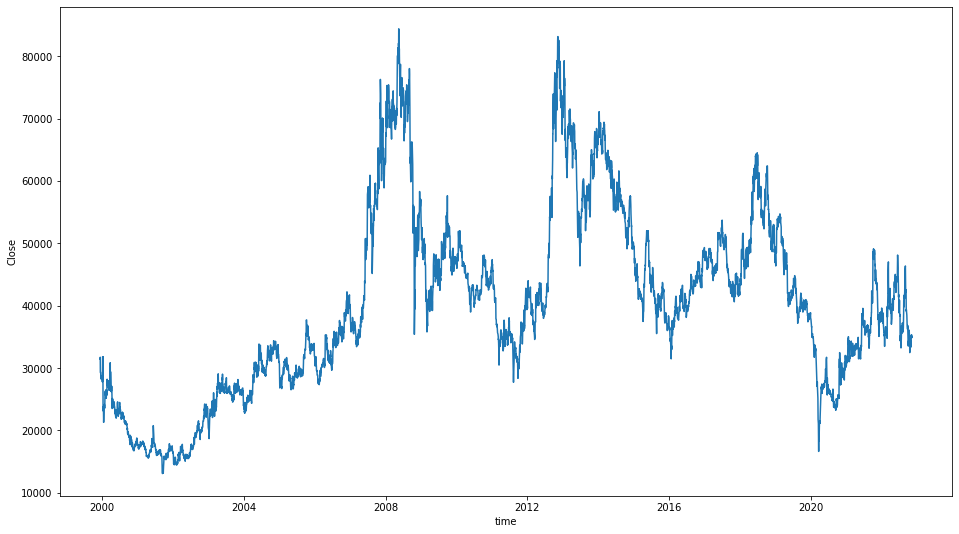

In [12]:
plt.figure(figsize=(16,9))
sns.lineplot(y=stock['Close'],x=stock.index)
plt.xlabel('time')
plt.show()

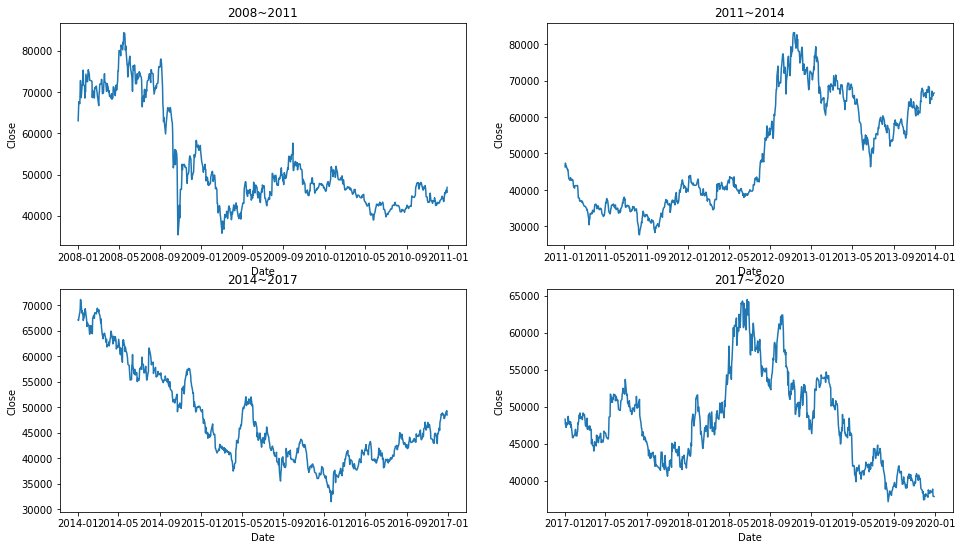

In [13]:
time_steps = [['2008','2011'],['2011','2014'],['2014','2017'],['2017','2020']]
fig, axes = plt.subplots(2,2)
fig.set_size_inches(16,9)

for i in range(4):
    ax = axes[i//2,i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x = df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
plt.show()

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open','High','Low','Close','Volume']

scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.26486706, 0.26      , 0.2541523 , 0.25745725, 0.1549396 ],
       [0.25270501, 0.27332414, 0.25625   , 0.26152229, 0.16658977],
       [0.250678  , 0.24798621, 0.2125    , 0.22764228, 0.08345012],
       ...,
       [0.30760198, 0.30703448, 0.31810345, 0.31188674, 0.01892872],
       [0.30620404, 0.30427586, 0.3137931 , 0.30557892, 0.02038953],
       [0.29711745, 0.30151724, 0.31020115, 0.30768153, 0.01033039]])

In [15]:
df = pd.DataFrame(scaled, columns=scale_cols)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5648 entries, 0 to 5647
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5648 non-null   float64
 1   High    5648 non-null   float64
 2   Low     5648 non-null   float64
 3   Close   5648 non-null   float64
 4   Volume  5648 non-null   float64
dtypes: float64(5)
memory usage: 220.8 KB


In [16]:
from sklearn.model_selection import train_test_split as tts

In [17]:
x_train, x_test, y_train, y_test = tts(df.drop('Close',1), df['Close'], test_size = 0.2, random_state=0, shuffle = False)

In [18]:
x_train.shape, y_train.shape

((4518, 4), (4518,))

In [19]:
import tensorflow as tf

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [21]:
WINDOW_SIZE = 20
BATCH_SIZE = 32

In [22]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [23]:
for data in train_data.take(1):
    print(f'데이터셋(x) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(x) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential([
    Conv1D(filters=32, kernel_size = 5,  
           padding='causal',
           activation='relu',
           input_shape=[WINDOW_SIZE,1]),
    LSTM(16, activation='tanh'),
    Dense(16, activation='relu'),
    Dense(1)


])

In [25]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer = optimizer, metrics = ['mse'])


In [26]:
earlystopping  = EarlyStopping(monitor = 'val_loss', patience=10)
filename = os.path.join('tmp', 'checkpointer.okpt')
checkpoint = ModelCheckpoint(filename,
                             save_weigt_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verboss=1)


In [27]:
history = model.fit(train_data,validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint,earlystopping])

Epoch 1/50
    141/Unknown - 13s 7ms/step - loss: 0.0013 - mse: 0.0025

141/141 [==============================] - 18s 47ms/step - loss: 0.0013 - mse: 0.0025 - val_loss: 2.9473e-04 - val_mse: 5.8945e-04
Epoch 2/50
136/141 [===========================>..] - ETA: 0s - loss: 2.8829e-04 - mse: 5.7658e-04

141/141 [==============================] - 7s 47ms/step - loss: 2.8828e-04 - mse: 5.7655e-04 - val_loss: 2.4537e-04 - val_mse: 4.9074e-04
Epoch 3/50
141/141 [==============================] - 1s 9ms/step - loss: 2.7039e-04 - mse: 5.4078e-04 - val_loss: 2.5326e-04 - val_mse: 5.0653e-04
Epoch 4/50
133/141 [===========================>..] - ETA: 0s - loss: 2.4599e-04 - mse: 4.9199e-04

141/141 [==============================] - 6s 39ms/step - loss: 2.4368e-04 - mse: 4.8735e-04 - val_loss: 2.1444e-04 - val_mse: 4.2887e-04
Epoch 5/50
141/141 [==============================] - ETA: 0s - loss: 2.1821e-04 - mse: 4.3642e-04

141/141 [==============================] - 6s 41ms/step - loss: 2.1821e-04 - mse: 4.3642e-04 - val_loss: 1.9170e-04 - val_mse: 3.8340e-04
Epoch 6/50
141/141 [==============================] - 1s 8ms/step - loss: 2.0676e-04 - mse: 4.1353e-04 - val_loss: 2.5344e-04 - val_mse: 5.0689e-04
Epoch 7/50
140/141 [============================>.] - ETA: 0s - loss: 1.9154e-04 - mse: 3.8307e-04

141/141 [==============================] - 6s 39ms/step - loss: 1.9106e-04 - mse: 3.8212e-04 - val_loss: 1.8483e-04 - val_mse: 3.6965e-04
Epoch 8/50
138/141 [============================>.] - ETA: 0s - loss: 1.9004e-04 - mse: 3.8007e-04

141/141 [==============================] - 6s 44ms/step - loss: 1.9078e-04 - mse: 3.8156e-04 - val_loss: 1.5501e-04 - val_mse: 3.1003e-04
Epoch 9/50
134/141 [===========================>..] - ETA: 0s - loss: 1.7692e-04 - mse: 3.5384e-04

141/141 [==============================] - 6s 43ms/step - loss: 1.7503e-04 - mse: 3.5006e-04 - val_loss: 1.4093e-04 - val_mse: 2.8186e-04
Epoch 10/50
133/141 [===========================>..] - ETA: 0s - loss: 1.8208e-04 - mse: 3.6415e-04

141/141 [==============================] - 7s 46ms/step - loss: 1.7897e-04 - mse: 3.5794e-04 - val_loss: 1.3917e-04 - val_mse: 2.7833e-04
Epoch 11/50
141/141 [==============================] - 1s 8ms/step - loss: 1.6388e-04 - mse: 3.2777e-04 - val_loss: 1.4541e-04 - val_mse: 2.9081e-04
Epoch 12/50
141/141 [==============================] - 1s 8ms/step - loss: 1.6798e-04 - mse: 3.3597e-04 - val_loss: 1.9736e-04 - val_mse: 3.9471e-04
Epoch 13/50
140/141 [============================>.] - ETA: 0s - loss: 1.6396e-04 - mse: 3.2793e-04

141/141 [==============================] - 6s 39ms/step - loss: 1.6367e-04 - mse: 3.2734e-04 - val_loss: 1.3214e-04 - val_mse: 2.6427e-04
Epoch 14/50
141/141 [==============================] - 1s 8ms/step - loss: 1.5673e-04 - mse: 3.1345e-04 - val_loss: 2.1015e-04 - val_mse: 4.2029e-04
Epoch 15/50
141/141 [==============================] - 1s 8ms/step - loss: 1.6614e-04 - mse: 3.3228e-04 - val_loss: 1.3523e-04 - val_mse: 2.7046e-04
Epoch 16/50
136/141 [===========================>..] - ETA: 0s - loss: 1.6359e-04 - mse: 3.2718e-04

141/141 [==============================] - 6s 42ms/step - loss: 1.6333e-04 - mse: 3.2665e-04 - val_loss: 1.2636e-04 - val_mse: 2.5272e-04
Epoch 17/50
141/141 [==============================] - ETA: 0s - loss: 1.6259e-04 - mse: 3.2517e-04

141/141 [==============================] - 6s 39ms/step - loss: 1.6259e-04 - mse: 3.2517e-04 - val_loss: 1.2241e-04 - val_mse: 2.4483e-04
Epoch 18/50
141/141 [==============================] - 1s 9ms/step - loss: 1.4954e-04 - mse: 2.9909e-04 - val_loss: 1.2245e-04 - val_mse: 2.4491e-04
Epoch 19/50
141/141 [==============================] - 1s 9ms/step - loss: 1.4402e-04 - mse: 2.8804e-04 - val_loss: 1.3291e-04 - val_mse: 2.6581e-04
Epoch 20/50
141/141 [==============================] - 2s 13ms/step - loss: 1.4709e-04 - mse: 2.9417e-04 - val_loss: 1.3732e-04 - val_mse: 2.7463e-04
Epoch 21/50
135/141 [===========================>..] - ETA: 0s - loss: 1.5144e-04 - mse: 3.0288e-04

141/141 [==============================] - 6s 42ms/step - loss: 1.4870e-04 - mse: 2.9739e-04 - val_loss: 1.1754e-04 - val_mse: 2.3508e-04
Epoch 22/50
141/141 [==============================] - 1s 8ms/step - loss: 1.4379e-04 - mse: 2.8758e-04 - val_loss: 1.2672e-04 - val_mse: 2.5344e-04
Epoch 23/50
141/141 [==============================] - 1s 10ms/step - loss: 1.3832e-04 - mse: 2.7663e-04 - val_loss: 1.3399e-04 - val_mse: 2.6799e-04
Epoch 24/50
141/141 [==============================] - 1s 8ms/step - loss: 1.4528e-04 - mse: 2.9057e-04 - val_loss: 1.3444e-04 - val_mse: 2.6887e-04
Epoch 25/50
138/141 [============================>.] - ETA: 0s - loss: 1.3565e-04 - mse: 2.7129e-04

141/141 [==============================] - 5s 38ms/step - loss: 1.3510e-04 - mse: 2.7019e-04 - val_loss: 1.1485e-04 - val_mse: 2.2971e-04
Epoch 26/50
141/141 [==============================] - 2s 14ms/step - loss: 1.4848e-04 - mse: 2.9695e-04 - val_loss: 1.2314e-04 - val_mse: 2.4627e-04
Epoch 27/50
137/141 [============================>.] - ETA: 0s - loss: 1.3963e-04 - mse: 2.7925e-04

141/141 [==============================] - 6s 42ms/step - loss: 1.3870e-04 - mse: 2.7741e-04 - val_loss: 1.1210e-04 - val_mse: 2.2421e-04
Epoch 28/50
140/141 [============================>.] - ETA: 0s - loss: 1.3610e-04 - mse: 2.7219e-04

141/141 [==============================] - 6s 39ms/step - loss: 1.3610e-04 - mse: 2.7220e-04 - val_loss: 1.1063e-04 - val_mse: 2.2127e-04
Epoch 29/50
141/141 [==============================] - 2s 15ms/step - loss: 1.3097e-04 - mse: 2.6194e-04 - val_loss: 1.2395e-04 - val_mse: 2.4790e-04
Epoch 30/50
141/141 [==============================] - 2s 13ms/step - loss: 1.3320e-04 - mse: 2.6640e-04 - val_loss: 1.1502e-04 - val_mse: 2.3004e-04
Epoch 31/50
141/141 [==============================] - 1s 9ms/step - loss: 1.3865e-04 - mse: 2.7731e-04 - val_loss: 1.8821e-04 - val_mse: 3.7642e-04
Epoch 32/50
141/141 [==============================] - 2s 10ms/step - loss: 1.4258e-04 - mse: 2.8515e-04 - val_loss: 1.3641e-04 - val_mse: 2.7282e-04
Epoch 33/50
141/141 [==============================] - 1s 8ms/step - loss: 1.2477e-04 - mse: 2.4954e-04 - val_loss: 1.1585e-04 - val_mse: 2.3170e-04
Epoch 34/50
141/141 [==============================] - 1s 8ms/step - loss: 1.3326e-04 - mse: 2.6652e-04 - val_loss

141/141 [==============================] - 6s 42ms/step - loss: 1.2872e-04 - mse: 2.5744e-04 - val_loss: 1.0699e-04 - val_mse: 2.1399e-04
Epoch 36/50
141/141 [==============================] - 1s 9ms/step - loss: 1.2205e-04 - mse: 2.4410e-04 - val_loss: 1.0730e-04 - val_mse: 2.1459e-04
Epoch 37/50
141/141 [==============================] - 1s 9ms/step - loss: 1.2819e-04 - mse: 2.5639e-04 - val_loss: 1.2406e-04 - val_mse: 2.4813e-04
Epoch 38/50
139/141 [============================>.] - ETA: 0s - loss: 1.2721e-04 - mse: 2.5441e-04

141/141 [==============================] - 6s 39ms/step - loss: 1.2678e-04 - mse: 2.5357e-04 - val_loss: 1.0417e-04 - val_mse: 2.0834e-04
Epoch 39/50
141/141 [==============================] - 1s 9ms/step - loss: 1.2746e-04 - mse: 2.5491e-04 - val_loss: 1.2171e-04 - val_mse: 2.4341e-04
Epoch 40/50
141/141 [==============================] - 1s 8ms/step - loss: 1.1966e-04 - mse: 2.3933e-04 - val_loss: 1.0759e-04 - val_mse: 2.1519e-04
Epoch 41/50
141/141 [==============================] - 1s 10ms/step - loss: 1.1974e-04 - mse: 2.3948e-04 - val_loss: 1.1368e-04 - val_mse: 2.2736e-04
Epoch 42/50
141/141 [==============================] - 1s 9ms/step - loss: 1.2262e-04 - mse: 2.4525e-04 - val_loss: 1.2962e-04 - val_mse: 2.5925e-04
Epoch 43/50
141/141 [==============================] - ETA: 0s - loss: 1.1513e-04 - mse: 2.3026e-04

141/141 [==============================] - 6s 43ms/step - loss: 1.1513e-04 - mse: 2.3026e-04 - val_loss: 1.0067e-04 - val_mse: 2.0135e-04
Epoch 44/50
141/141 [==============================] - ETA: 0s - loss: 1.1441e-04 - mse: 2.2883e-04

141/141 [==============================] - 6s 42ms/step - loss: 1.1441e-04 - mse: 2.2883e-04 - val_loss: 1.0051e-04 - val_mse: 2.0103e-04
Epoch 45/50
141/141 [==============================] - 1s 9ms/step - loss: 1.1623e-04 - mse: 2.3246e-04 - val_loss: 1.0238e-04 - val_mse: 2.0476e-04
Epoch 46/50
141/141 [==============================] - 1s 9ms/step - loss: 1.2216e-04 - mse: 2.4432e-04 - val_loss: 1.0284e-04 - val_mse: 2.0568e-04
Epoch 47/50
141/141 [==============================] - 1s 9ms/step - loss: 1.2074e-04 - mse: 2.4148e-04 - val_loss: 1.0904e-04 - val_mse: 2.1808e-04
Epoch 48/50
141/141 [==============================] - 1s 9ms/step - loss: 1.2063e-04 - mse: 2.4126e-04 - val_loss: 1.0294e-04 - val_mse: 2.0587e-04
Epoch 49/50
132/141 [===========================>..] - ETA: 0s - loss: 1.1565e-04 - mse: 2.3130e-04

141/141 [==============================] - 6s 40ms/step - loss: 1.1567e-04 - mse: 2.3133e-04 - val_loss: 9.9776e-05 - val_mse: 1.9955e-04
Epoch 50/50
141/141 [==============================] - 1s 9ms/step - loss: 1.1417e-04 - mse: 2.2833e-04 - val_loss: 9.9916e-05 - val_mse: 1.9983e-04


In [28]:
model.load_weights(filename)

In [29]:
pre = model.predict(test_data)

35/35 [==============================] - 2s 10ms/step


In [30]:
pre.shape


(1110, 1)

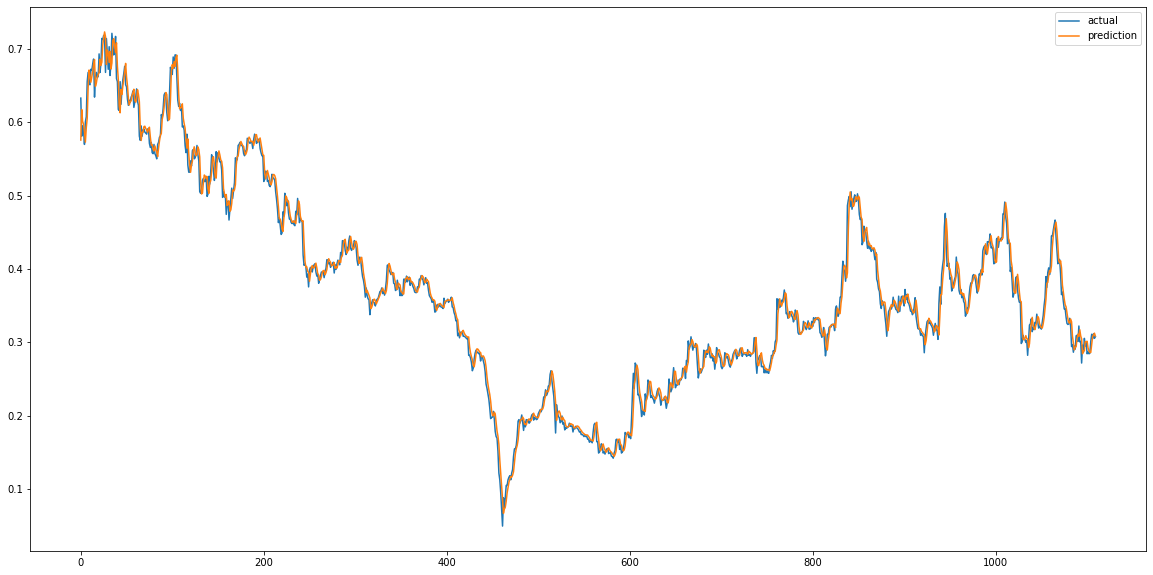

In [31]:
plt.figure(figsize=(20,10))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pre,label='prediction')
plt.legend()
plt.show()